<a href="https://colab.research.google.com/github/mjvakili/Land_use_classification/blob/master/land_cover_vanila_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **このノートブックについて**

---


本ノートブックは深層学習の最初の第一歩として自学自習や研修等でお使いいただけるよう、元村和史(Kazushi Motomura)が作成、公開しているものです。

自由にお使いいただけますが、よりよいノートブックに出来ればと思っておりますので、使用した感想等を作成者にお寄せ頂けると幸いです。私自身もまだまだ勉強中ですので、是非よろしくお願いいたします。

このノートブックはPythonの基本的なコードで書かれてはいるものの、その使い方を一行一行解説するものではありません。
ただし、特に知識がなくてもGoogleColabratry上で「Shift+Enter」を連打すればとにかく動くように作っています。動いている深層学習モデルを触って動かすことが出来るので、Pythonにそこまで馴染みがなくても、「何となく」深層学習モデルを作成して、動かしてみることができます。(試しに「Shift+Enter」を連打して最後まで進めてみてください)

何となく動いてしまうので、馴染みのない方は気持ち悪く感じるかもしれませんが、まさにそれが入り口です。このノートブックに書かれているコードは基本的なものばかりですので1行1行何をしているのか調べながら追っていただくことで、Pythonの勉強の導入としてお使いいただけると思います。

本ノートブックの作成に当たって参考にしたサイト等は以下です。是非ご活用ください。

*   https://github.com/LinguoLi/mnist_tutorial
*   https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
* https://github.com/yashk2810/MNIST-Keras



このコードはSentinel-2衛星画像（<a ref="https://github.com/phelber/EuroSAT">Eurosat</a>）を使って土地被覆分類を行うノートブックです。
コードは<a ref="https://github.com/mjvakili/Land_use_classification/blob/master/land_cover_vanila_classification.ipynb">Land_use_classification</a>を参考に作成しています。

# 必要なライブラリのロード

In [ ]:
import os
import zipfile
import matplotlib
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.image as mpimg
from glob import glob 
%matplotlib inline
from matplotlib.colors import LogNorm
#Keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
#sklearn helpers
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

# EuroSATデータのロード
EuroSATの衛星データをダウンロードします。ダウンロードは一時的にColabに保存されますが、使用後になくなります。

In [ ]:
#Download the file and save it in a temporary placeholder '/tmp'
!wget --no-check-certificate http://madm.dfki.de/files/sentinel/EuroSAT.zip -O /tmp/eurosat.zip

--2021-01-07 12:08:26--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘/tmp/eurosat.zip’

/tmp/eurosat.zip    100%[===================>]  89.91M  12.1MB/s    in 12s     

2021-01-07 12:08:39 (7.46 MB/s) - ‘/tmp/eurosat.zip’ saved [94280567/94280567]



ダウンロードしたデータを解凍します。

In [ ]:
#Unzip the file in '/tmp'
local_zip = '/tmp/eurosat.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

ダウンロードしたデータを可視化して確認します。

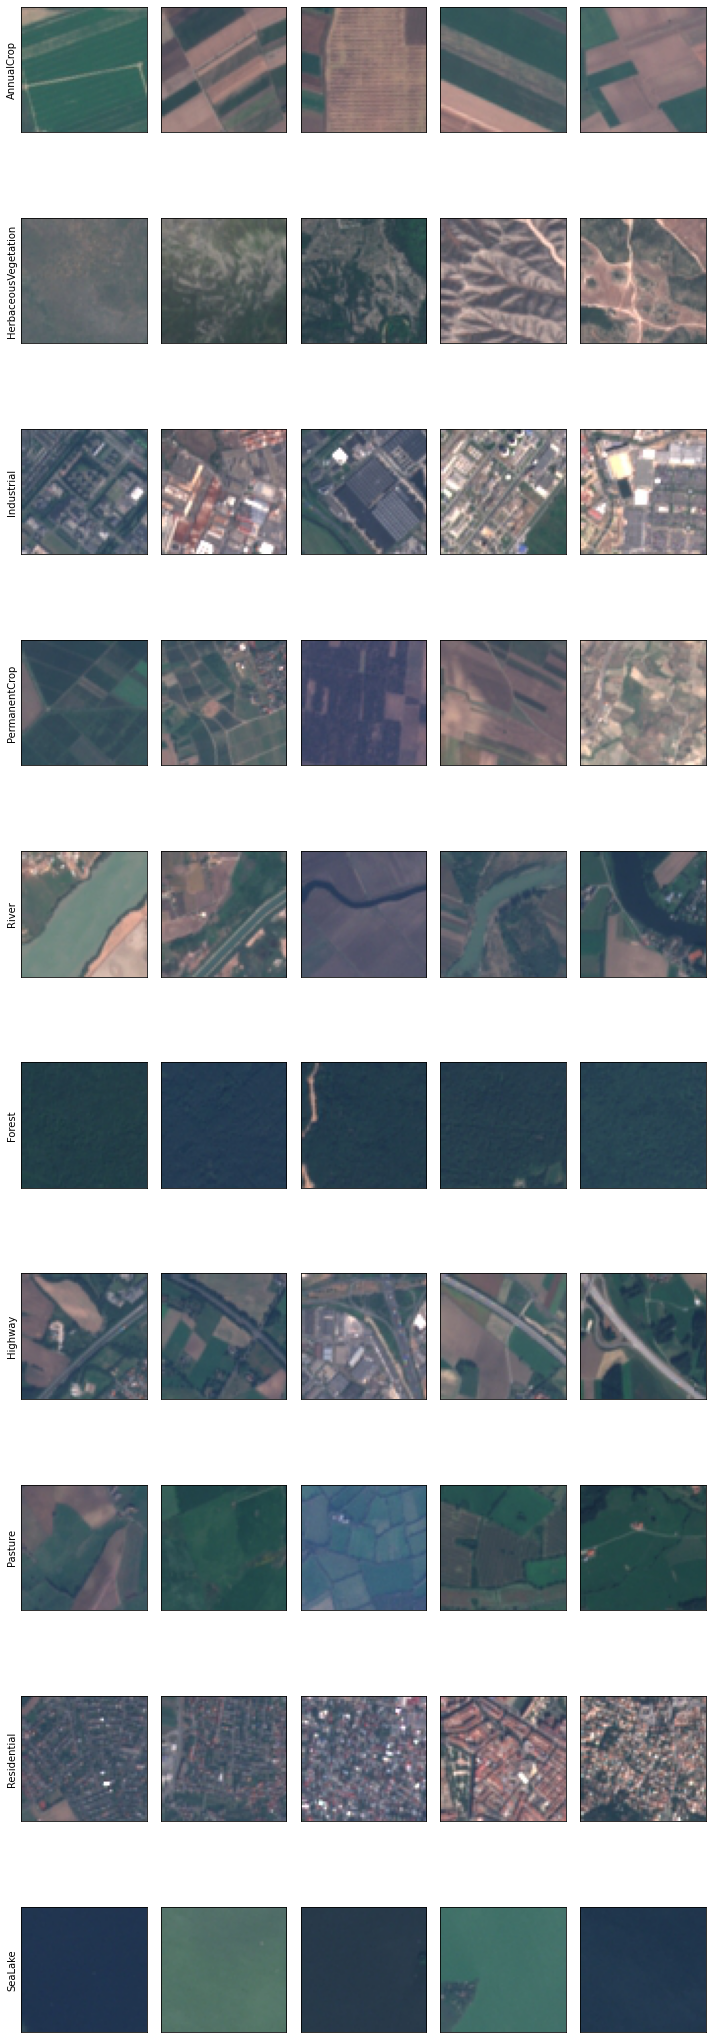

In [ ]:
base_dir = "/tmp/2750"
Classes = ["AnnualCrop","HerbaceousVegetation","Industrial","PermanentCrop","River","Forest","Highway","Pasture","Residential","SeaLake"]
NC = len(Classes)
Ncols = 5
Nsamples = []
fig, ax = plt.subplots(nrows = NC, ncols = Ncols, figsize = (10,30))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for (i,Class) in enumerate(Classes):
  
  Class_dir = os.path.join(base_dir, Class)
  Class_files = os.listdir(Class_dir)
  nsamples = len(Class_files)
  Nsamples.append(nsamples)
  Class_samples = Class_files[:Ncols]
  
  for j in range(Ncols):
    
    img_path = os.path.join(Class_dir, Class_samples[j])
    img = mpimg.imread(img_path)
    ax[i, j].imshow(img)
    ax[i,0].set_ylabel(Class, fontsize = 10)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

plt.tight_layout()  

ダウンロードしたデータのクラス別の数を確認します。

Text(0, 0.5, 'Number of instances in each class')

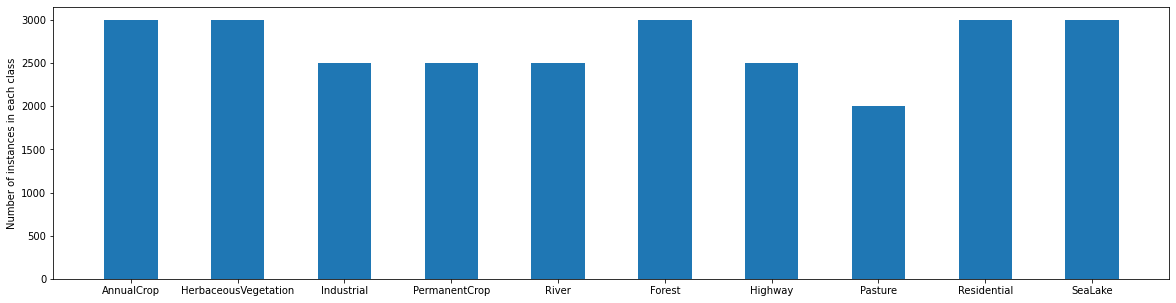

In [ ]:
plt.figure(figsize = (20,5))
plt.bar(Classes, Nsamples, width = 0.5, color = "C0", label='Alone')
plt.ylabel("Number of instances in each class", fontsize  = 10)

# 学習用データの準備
ダウンロードしたデータを学習用に分割します。

In [ ]:
LR = 0.001
BATCH_SIZE = 64
NEPOCHS = 15
IMG_WIDTH, IMG_HEIGHT = 75, 75
VALIDATION_RATIO = 0.2

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip=True,
    validation_split=VALIDATION_RATIO) # set validation split

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') 

validation_generator = datagen.flow_from_directory(
    base_dir, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') 

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


# 畳み込みニューラルネットワークの構築
  畳み込みニューラルネットワークを構築します。

In [ ]:
def simple_model():
    model = models.Sequential([
      # The input shape is size of the image from the data generator IMG_WIDTHxIMG_HEIGHT with 3 channel color
      layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
      layers.MaxPooling2D(2, 2),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2,2),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(512, activation='relu'),
      layers.Dense(10, activation='softmax')])
    return model

In [ ]:
model = simple_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         1

# 畳み込みニューラルネットワークの学習
学習パラメータを設定して、学習させます。

## 学習パラメータの設定

In [ ]:
#Stop the optimization once the validation accuracy converges
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

#Schedul the learning rate
def scheduler(epoch):
  '''
  learning rate scheduler; keeps the learning rate 10^(-3) until 10 and then exponential decrease
  '''
  if epoch < 10:
    return LR
  else:
    return LR * np.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = LR), metrics=['accuracy'])

## 学習

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=10, 
                              validation_data = validation_generator,
                              callbacks=[early_stopping, learning_rate_scheduler], 
                              verbose = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
338/338 [==============================] - 49s 125ms/step - loss: 1.7550 - accuracy: 0.3069 - val_loss: 1.2171 - val_accuracy: 0.5185
Epoch 2/10
338/338 [==============================] - 42s 123ms/step - loss: 1.1629 - accuracy: 0.5361 - val_loss: 0.9946 - val_accuracy: 0.6335
Epoch 3/10
338/338 [==============================] - 42s 124ms/step - loss: 0.9389 - accuracy: 0.6638 - val_loss: 0.7212 - val_accuracy: 0.7326
Epoch 4/10
338/338 [==============================] - 41s 123ms/step - loss: 0.7908 - accuracy: 0.7129 - val_loss: 0.7036 - val_accuracy: 0.7407
Epoch 5/10
338/338 [==============================] - 41s 121ms/step - loss: 0.7351 - accuracy: 0.7361 - val_loss: 0.6716 - val_accuracy: 0.7539
Epoch 6/10
338/338 [==============================] - 41s 121ms/step - loss: 0.6708 - accuracy: 0.7583 - val_loss: 0.6557 - val_accuracy: 0.7593
Epoch 7/10
338/338 [==============================] - 41s 121ms/step - loss: 0.6358 - accuracy: 0.7749 - val_loss: 0.5139 - val_ac

## モデルの保存

In [ ]:
model.save("land_use.h5")

# 学習結果の確認

## 学習曲線の確認

In [ ]:
def plot_history(history):
  
  plt.figure(figsize = (10,6))
  plt.subplot(1,2,1)
  plt.plot(history.history["loss"], label = "loss")
  plt.plot(history.history["val_loss"], label = "validation loss")
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history["accuracy"], label = "accuracy")
  plt.plot(history.history["val_accuracy"], label = "validation accuracy")
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  return None

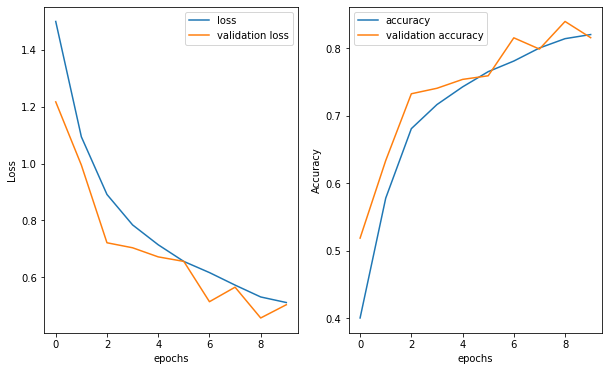

In [ ]:
plot_history(history)

# テストデータの生成

In [ ]:
testing_generator = datagen.flow_from_directory(
                        base_dir, 
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=5400,
                        class_mode='categorical',
                        shuffle = False,
                        subset='validation')
test_labels = testing_generator.labels

Found 5400 images belonging to 10 classes.


# モデルによる予測

In [ ]:
test_preds = model.predict_generator(testing_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


# 予測結果の評価

In [ ]:
test_best = test_preds.argmax(axis = -1)

In [ ]:
report = classification_report(test_labels,
                               test_best,
                               labels = np.arange(10),
                               target_names = Classes)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.76      0.82       600
HerbaceousVegetation       0.80      0.99      0.88       600
          Industrial       0.60      0.87      0.71       600
       PermanentCrop       0.80      0.74      0.77       500
               River       0.96      0.81      0.88       500
              Forest       0.82      0.70      0.76       400
             Highway       0.77      0.54      0.64       500
             Pasture       0.81      0.99      0.89       600
         Residential       0.87      0.67      0.76       500
             SeaLake       0.98      0.95      0.96       600

            accuracy                           0.81      5400
           macro avg       0.83      0.80      0.81      5400
        weighted avg       0.83      0.81      0.81      5400



# 予測画像の確認

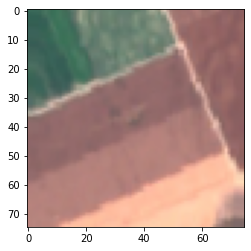

Highway


In [ ]:
x,y = testing_generator.next()
Classes = ["AnnualCrop","HerbaceousVegetation","Industrial","PermanentCrop","River","Forest","Highway","Pasture","Residential","SeaLake"]
num = 100
image = x[num]
plt.imshow(image)
plt.show()
print(Classes[np.argmax(test_preds[num])])